### Load stored dataframe from file

In [42]:
import pandas as pd
import pickle

# convert back
data = pd.read_pickle('vars/data.pkl')
with open('vars/avg_dicts.pkl', 'rb') as f:
    avg_dicts = pickle.load(f)
with open('vars/profile_dicts.pkl', 'rb') as f:
    profile_dicts = pickle.load(f)
with open('vars/timing_dicts.pkl', 'rb') as f:
    timing_dicts = pickle.load(f)

### Imports and redefine helpful globals

In [44]:
from enum import IntEnum
import os.path
import numpy as np
import sys 
import re
import scipy.misc
import scipy.integrate
from matplotlib.pyplot import *
%matplotlib inline

# redefine other variables
pressure_names = ["hard", "soft"]
material_names = ["cloth", "concrete", "door", "drywall", "laminant", "whiteboard"]
pressure_plotnames = ["Hard", "Soft"]
material_plotnames = ["cloth", "concrete", "door", "drywall", "laminant", "whiteboard"]
names = ["user"+str(i) for i in range(10)]
HARD_COLOR = (0,0,0)
SOFT_COLOR = (0.6, 0.6, 0.6)

class Pressure(IntEnum):
    HARD = 0
    SOFT = 1

class Material(IntEnum):
    CLOTH      = 0                                                              
    CONCRETE   = 1                                                              
    DOOR       = 2                                                              
    DRYWALL    = 3                                                              
    LAMINANT   = 4                                                              
    WHITEBOARD = 5

### Define boxplotting function

In [45]:
def setBoxColors(bp):
    setp(bp['boxes'][0], color=HARD_COLOR)
    #bp['boxes'].set_facecolor(HARD_COLOR)
    setp(bp['caps'][0], color=HARD_COLOR)
    setp(bp['caps'][1], color=HARD_COLOR)
    setp(bp['whiskers'][0], color=HARD_COLOR)
    setp(bp['whiskers'][1], color=HARD_COLOR)
    setp(bp['medians'][0], color='w')
    setp(bp['fliers'][0], color=HARD_COLOR, marker='.')
    bp['fliers'][1].set_markeredgecolor(HARD_COLOR)

    setp(bp['boxes'][1], color=SOFT_COLOR)
    #bp['boxes'][1].set_facecolor(SOFT_COLOR)
    setp(bp['caps'][2], color=SOFT_COLOR)
    setp(bp['caps'][3], color=SOFT_COLOR)
    setp(bp['whiskers'][2], color=SOFT_COLOR)
    setp(bp['whiskers'][3], color=SOFT_COLOR)
    setp(bp['medians'][1], color='w')
    setp(bp['fliers'][1], color=SOFT_COLOR, marker='.')
    bp['fliers'][1].set_markeredgecolor(SOFT_COLOR)

In [46]:
########################################
### PER-USER TOTAL INTENSITY BOXPLOT ###
########################################
def boxplot_total_intensities(mat, hard_swipes, soft_swipes):
    fig = figure()
    ax = axes()


    # plot each user individually
    for idx, name in enumerate(names):
        bp = boxplot([hard_swipes[name], soft_swipes[name]],
                        positions = [3*idx, 3*idx+1],
                        patch_artist = True,
                        widths = 0.8)
        setBoxColors(bp)

    # plot all users together
    all_soft = []
    all_hard = []
    for name in names:
        all_hard += hard_swipes[name]
        all_soft += soft_swipes[name]

    bp = boxplot([all_hard, all_soft],
                    positions=[3*len(names), 3*len(names)+1],
                    patch_artist = True,
                    widths=0.8)
    setBoxColors(bp)

    #title('Per-user average swipe intensity')
    xlim(-1,29)
    ax.set_xticklabels([str(i) for i in range(9)]+["all"], fontsize=12)
    ax.set_xticks(np.arange(0.5,29,3))
    #ax.set_xticks(np.arange(0,21,2))
    title(material_plotnames[mat.value])
    xlabel("User", fontsize=12)
    ylabel("Average swipe pixel intensity", fontsize=12)
    hl, = plot([1,1], c=HARD_COLOR, linewidth=5.0)
    sl, = plot([1,1], c=SOFT_COLOR, linewidth=5.0)
    legend((hl, sl),('hard swipes', 'soft swipes'), fontsize=12, framealpha=0.5, loc=9)
    hl.set_visible(False)
    sl.set_visible(False)
    show()

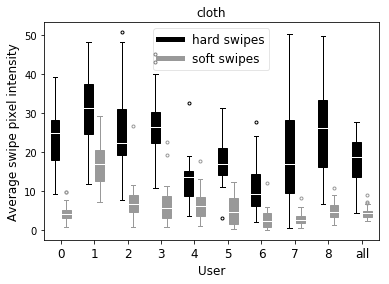

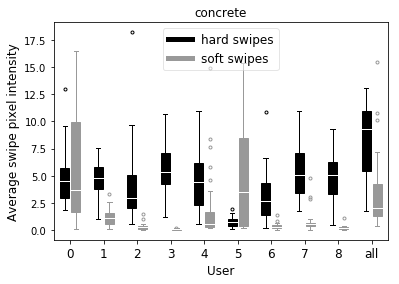

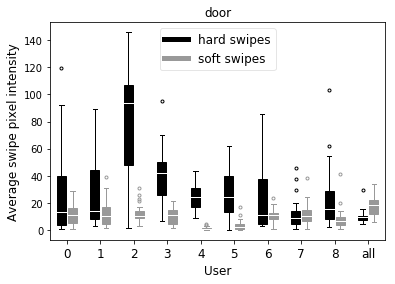

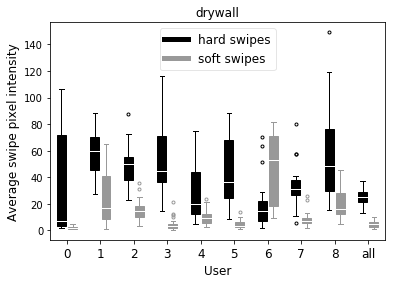

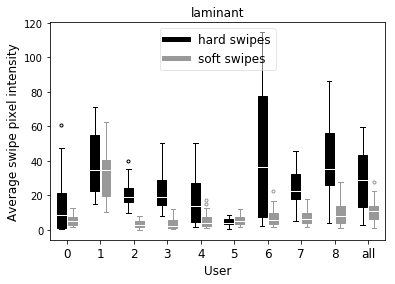

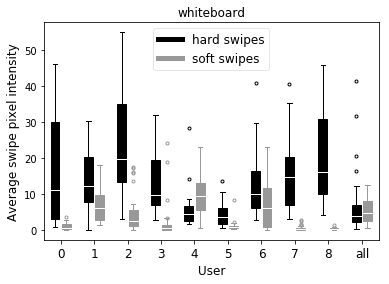

In [47]:
for mat in Material:
    boxplot_total_intensities(mat, avg_dicts[mat.value][Pressure.HARD.value], avg_dicts[mat.value][Pressure.SOFT.value])

In [48]:
############################################
### PER-USER AVERAGE SWIPE PROFILE GRAPH ###
############################################
def plot_swipe_profiles(mat, hard_profile, soft_profile, plot_type='mean'):
    N_BINS = 10

    fig = figure()
    ax = axes()
    for name in names:

        # find max and avg swipe intensity for each bin
        user_hardswipe_avg_bins = [0]*N_BINS
        user_hardswipe_max_bins = [0]*N_BINS
        for pt in hard_profile[name]:
            bin_idx = int(pt[0] * N_BINS)
            user_hardswipe_avg_bins[bin_idx] += pt[1]
            user_hardswipe_max_bins[bin_idx] = max(user_hardswipe_max_bins[bin_idx], pt[1])

        # find max and avg swipe intensity for each bin
        user_softswipe_avg_bins = [0]*N_BINS
        user_softswipe_max_bins = [0]*N_BINS
        for pt in soft_profile[name]:
            bin_idx = int(pt[0] * N_BINS)
            user_softswipe_avg_bins[bin_idx] += pt[1]
            user_softswipe_max_bins[bin_idx] = max(user_softswipe_max_bins[bin_idx], pt[1])

        if plot_type == 'mean':
            plot(user_hardswipe_avg_bins, marker='.', c=HARD_COLOR)
            plot(user_softswipe_avg_bins, marker='.', c=SOFT_COLOR)
        elif plot_type == 'max':
            plot(user_hardswipe_max_bins, marker='.', c=HARD_COLOR)
            plot(user_softswipe_max_bins, marker='.', c=SOFT_COLOR)

    #title('Per-user swipe profile distribution')
    legend(['user\'s hard swipes', 'user\'s soft swipes'], fontsize=12)
    xlabel('Bins containing 10% sections of swipe length', fontsize=12)
    title(material_plotnames[mat.value])
    if plot_type == 'mean':
        ylabel('Average pixel intensity within bin', fontsize=12)
    elif plot_type == 'max':
        ylabel('Maximum pixel intensity within bin', fontsize=12)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_xticks(np.arange(0,N_BINS))
    xticks(fontsize=12)
    #ax.set_xticklabels(np.arange(0,), fontsize=12)
    show()

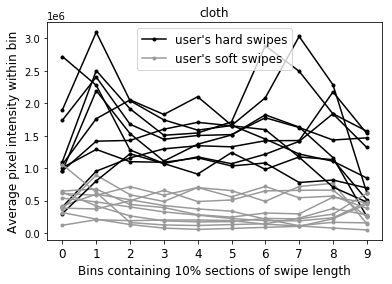

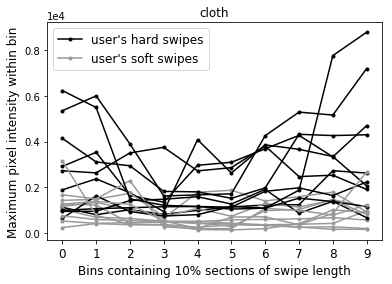

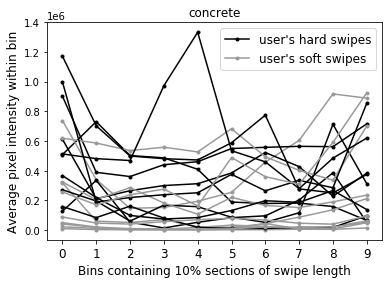

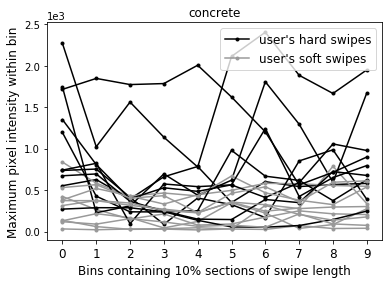

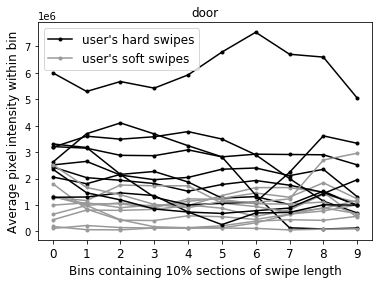

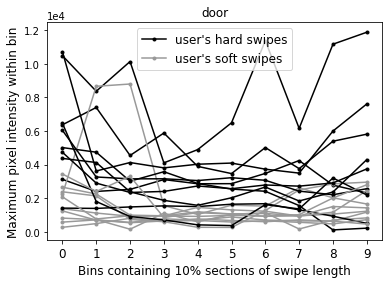

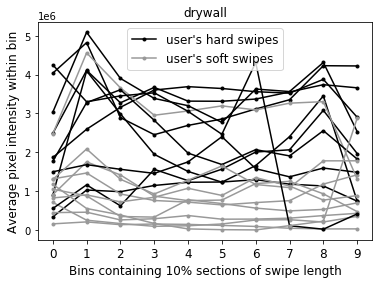

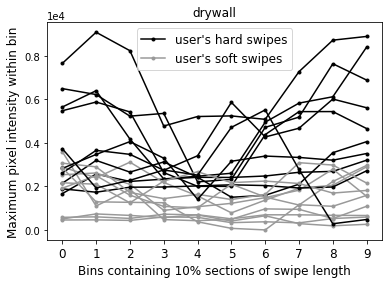

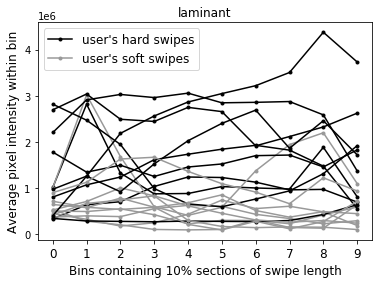

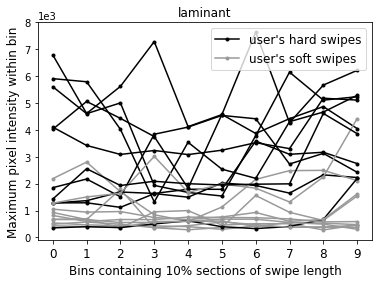

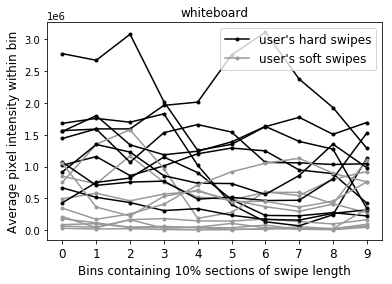

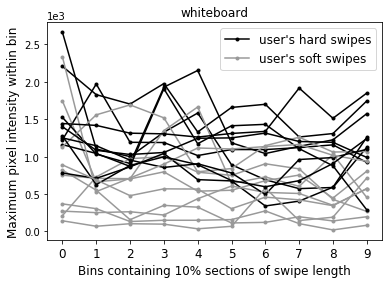

In [49]:
for mat in Material:
    plot_swipe_profiles(mat, profile_dicts[mat.value][Pressure.HARD.value], profile_dicts[mat.value][Pressure.SOFT.value])
    plot_swipe_profiles(mat, profile_dicts[mat.value][Pressure.HARD.value], profile_dicts[mat.value][Pressure.SOFT.value], plot_type='max')

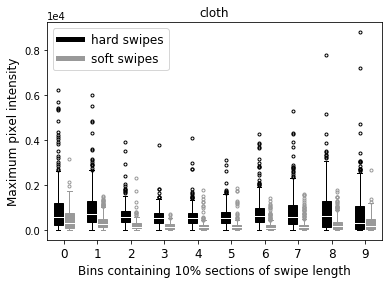

/home/dunntj/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


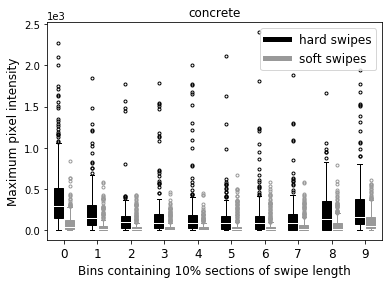

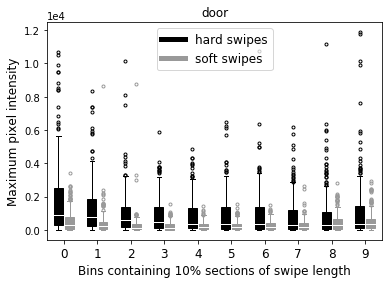

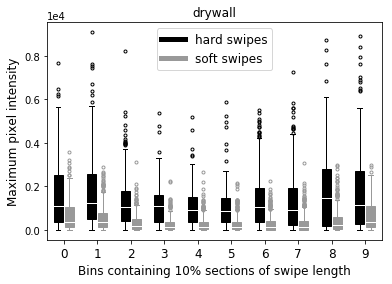

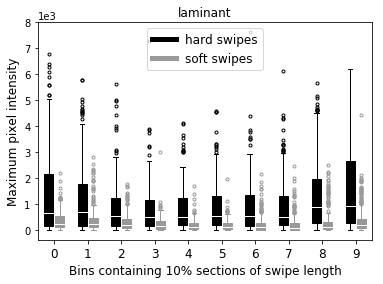

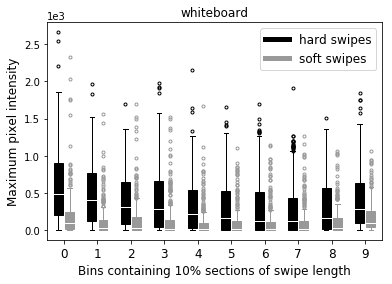

In [50]:
#####################################
### BOXPLOT OF MAX SWIPE PROFILES ###
#####################################
for mat in Material:
    fig = figure()
    ax = axes()
    N_BINS = 10
    for i in range(N_BINS):
        bp = boxplot([data[ (data["pressure"]=='hard') & (data["material"] == material_names[mat.value]) ]["maxbin"+str(i)], 
                      data[ (data["pressure"]=='soft') & (data["material"] == material_names[mat.value]) ]['maxbin'+str(i)]],
                      positions=[3*i, 3*i+1],
                      patch_artist=True,
                      widths=0.8)
        setBoxColors(bp)

    hl, = plot([1,1], c=HARD_COLOR, linewidth=5.0)
    sl, = plot([1,1], c=SOFT_COLOR, linewidth=5.0)
    legend((hl, sl),('hard swipes', 'soft swipes'), fontsize=12)
    xlim(-1, 29)
    ax.set_xticklabels([str(i) for i in range(N_BINS)], fontsize=12)
    ax.set_xticks(np.arange(0.5, 29, 3))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    title(material_plotnames[mat.value])
    ylabel("Maximum pixel intensity", fontsize=12)
    xlabel("Bins containing 10% sections of swipe length", fontsize=12)
    xticks(fontsize=12)
    hl.set_visible(False)
    sl.set_visible(False)
    show()

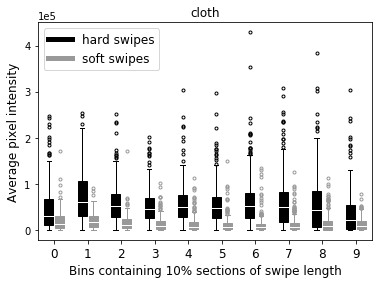

/home/dunntj/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


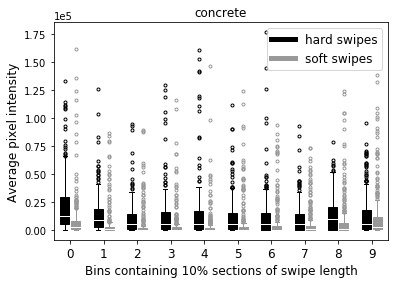

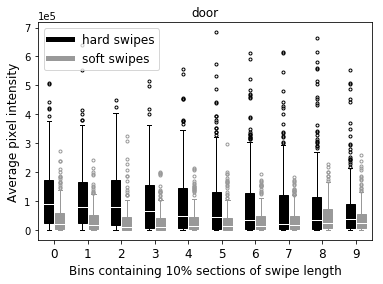

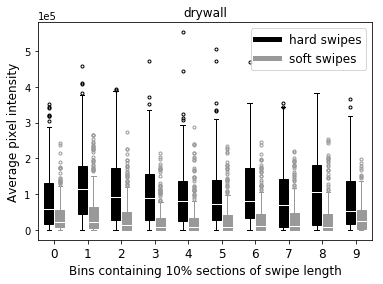

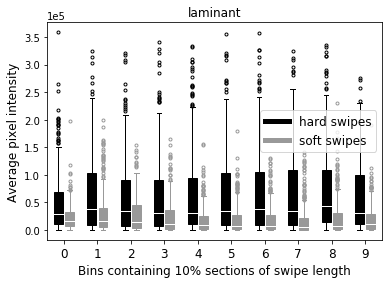

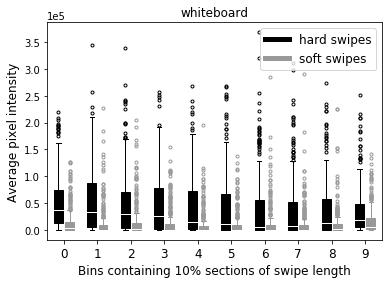

In [51]:
#####################################
### BOXPLOT OF AVG SWIPE PROFILES ###
#####################################
for mat in Material:
    fig = figure()
    ax = axes()
    N_BINS = 10
    for i in range(N_BINS):
        bp = boxplot([data[(data["pressure"]=='hard')&(data['material'] == material_names[mat.value])]["avgbin"+str(i)], 
                      data[(data["pressure"]=='soft')&(data['material'] == material_names[mat.value])]['avgbin'+str(i)]],
                      positions=[3*i, 3*i+1],
                      patch_artist=True,
                      widths=0.8)
        setBoxColors(bp)

    hl, = plot([1,1], c=HARD_COLOR, linewidth=5.0)
    sl, = plot([1,1], c=SOFT_COLOR, linewidth=5.0)
    legend((hl, sl),('hard swipes', 'soft swipes'), fontsize=12)
    xlim(-1, 29)
    ax.set_xticklabels([str(i) for i in range(N_BINS)], fontsize=12)
    ax.set_xticks(np.arange(0.5, 29, 3))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    title(material_plotnames[mat.value])
    ylabel("Average pixel intensity", fontsize=12)
    xlabel("Bins containing 10% sections of swipe length", fontsize=12)
    xticks(fontsize=12)
    hl.set_visible(False)
    sl.set_visible(False)
    show()

In [52]:
#####################################
### PER-USER TIME INTENSITY GRAPH ###
#####################################
EPSILON = 0.001
MAX_FRAMES = 150

def plot_time_intensities(mat, hard_timing, soft_timing):
    N_BINS = 10
    FRAME_RATE = 30

    fig = figure()
    ax = axes()
    for name in names:

        # find max and avg swipe intensity for each bin
        user_hardtime_avg_bins = [0]*N_BINS
        for pt in hard_timing[name]:
            bin_idx = int(np.floor(((pt[0]-EPSILON)/MAX_FRAMES) * N_BINS))
            user_hardtime_avg_bins[bin_idx] += pt[1]

        # find max and avg swipe intensity for each bin
        user_softtime_avg_bins = [0]*N_BINS
        for pt in soft_timing[name]:
            bin_idx = int(np.floor(((pt[0]-EPSILON)/MAX_FRAMES) * N_BINS))
            user_softtime_avg_bins[bin_idx] += pt[1]


        plot(user_hardtime_avg_bins, marker='.', c=HARD_COLOR)
        plot(user_softtime_avg_bins, marker='.', c=SOFT_COLOR)


    #title('Per-user swipe profile distribution')
    legend(['hard swipes', 'soft swipes'], fontsize=12)
    title(material_plotnames[mat.value])
    xlabel('Bins containing 0.5 second time intervals', fontsize=12)
    ylabel('Average pixel intensity', fontsize=12)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_xticks(np.arange(0,N_BINS,N_BINS/10))
    ax.set_xticklabels(np.arange(0,N_BINS), fontsize=12)
    show()

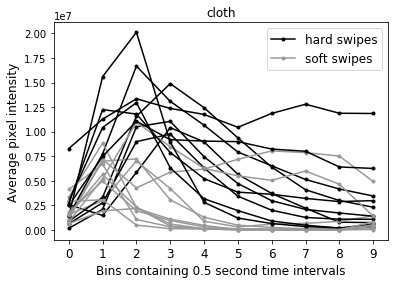

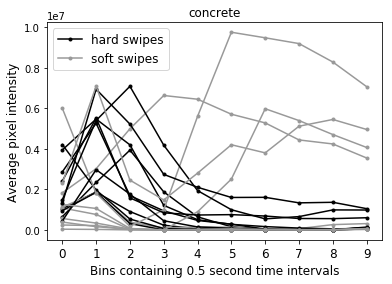

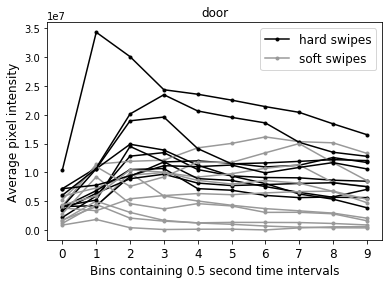

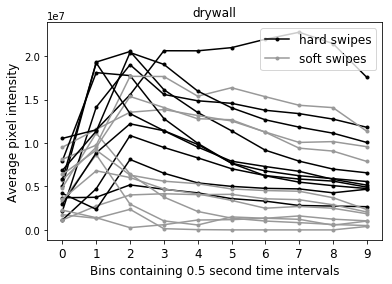

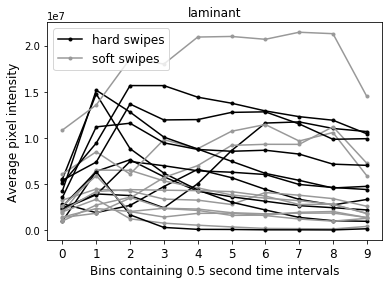

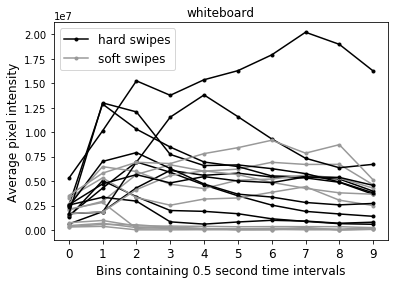

In [53]:
for mat in Material:
    plot_time_intensities(mat, timing_dicts[mat.value][Pressure.HARD.value], timing_dicts[mat.value][Pressure.SOFT.value])

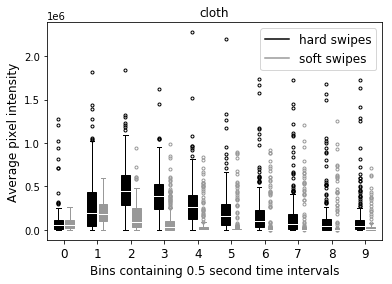

/home/dunntj/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


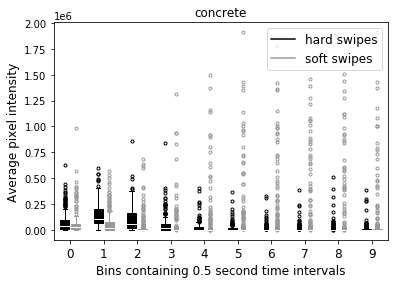

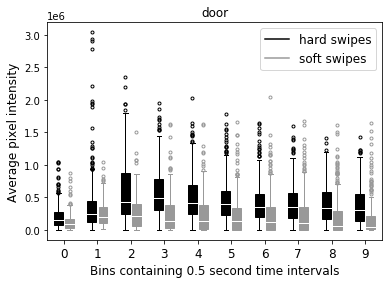

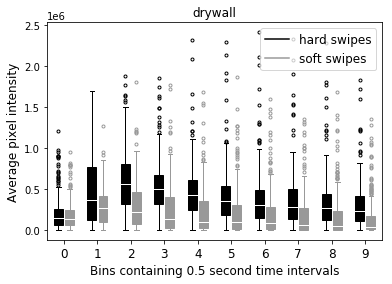

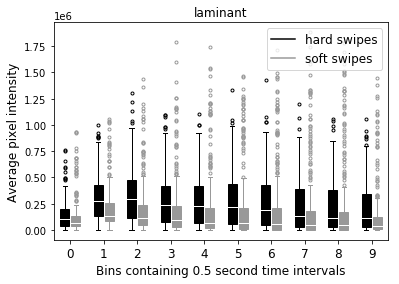

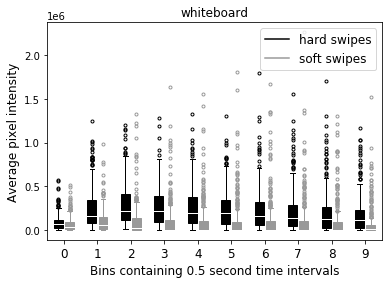

In [54]:
#######################################
### BOXPLOT OF AVG TIME INTENSITIES ###
#######################################
for mat in Material:
    fig = figure()
    ax = axes()
    N_BINS = 10
    for i in range(N_BINS):
        bp = boxplot([data[(data["pressure"]=='hard')&(data['material']==material_names[mat.value])]["timebin"+str(i)], 
                      data[(data["pressure"]=='soft')&(data['material']==material_names[mat.value])]['timebin'+str(i)]],
                      positions=[3*i, 3*i+1],
                      patch_artist=True,
                      widths=0.8)
        setBoxColors(bp)

    hl, = plot([1,1], c=HARD_COLOR)
    sl, = plot([1,1], c=SOFT_COLOR)
    legend((hl, sl),('hard swipes', 'soft swipes'), fontsize=12, loc=1)
    xlim(-1, 29)
    ax.set_xticklabels([str(i) for i in range(N_BINS)], fontsize=12)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_xticks(np.arange(0.5, 29, 3))
    title(material_plotnames[mat.value])
    ylabel("Average pixel intensity", fontsize=12)
    xlabel("Bins containing 0.5 second time intervals", fontsize=12)
    hl.set_visible(False)
    sl.set_visible(False)
    show()

### Randomly sample 20 swipes for each (user/material/pressure) combination

In [56]:
data2 = pd.DataFrame(columns=data.columns)
for name in names:
    for mat in Material:
        for pres in Pressure:
            temp = data[ (data['name'] == name)&(data['material'] == material_names[mat.value])&(data['pressure'] == pressure_names[pres.value]) ]
            data2 = data2.append(temp.sample(n=min(25, temp.shape[0])), ignore_index=True)
#data2

In [57]:
##############################
### FINAL CONFUSION MATRIX ###
##############################

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE

MATERIAL = 2
data3 = data2[data2['material'] == material_names[MATERIAL]].copy()
data3 = data3.reset_index(drop=True)

# encode categorical variables
le = LabelEncoder()
data3['pressure'] = le.fit_transform(data3.pressure)
data3['name'] = le.fit_transform(data3.name)
data3['material'] = le.fit_transform(data3.material)

# define feature columns
feature_cols = [x for x in data3.columns if "bin" in x] + ["avg", "max", "total_time"]
print(feature_cols)

# columns should have zero mean and unit variance
ss = StandardScaler()
data3[feature_cols] = ss.fit_transform(data3[feature_cols])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
train_idx, test_idx = next(sss.split(data3[feature_cols], data3.name))

X_train = data3.loc[train_idx, feature_cols]
y_train = data3.loc[train_idx, 'pressure']

X_test  = data3.loc[test_idx, feature_cols]
y_test  = data3.loc[test_idx, 'pressure']


rfc = RandomForestClassifier(n_estimators = 500, max_features=6)
rfc = rfc.fit(X_train, y_train)

['avgbin0', 'avgbin1', 'avgbin2', 'avgbin3', 'avgbin4', 'avgbin5', 'avgbin6', 'avgbin7', 'avgbin8', 'avgbin9', 'maxbin0', 'maxbin1', 'maxbin2', 'maxbin3', 'maxbin4', 'maxbin5', 'maxbin6', 'maxbin7', 'maxbin8', 'maxbin9', 'timebin0', 'timebin1', 'timebin2', 'timebin3', 'timebin4', 'timebin5', 'timebin6', 'timebin7', 'timebin8', 'timebin9', 'avg', 'max', 'total_time']


/home/dunntj/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/dunntj/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [60]:
cms = np.ndarray(shape=(10,2,2)).astype(int)
y_pred = rfc.predict(X_test)
u_test = data3.loc[test_idx, 'name']

for i, user in enumerate(u_test):
    if y_test.tolist()[i] == 0:
        if y_pred[i] == 0:
            cms[user][0][0] += 1
        else:
            cms[user][0][1] += 1
    else: # y_pred == 1
        if y_pred[i] == 0:
            cms[user][1][0] += 1
        else:
            cms[user][1][1] += 1
print(cms)

[[[ 5  2]
  [ 3 15]]

 [[12  1]
  [ 0 12]]

 [[13  0]
  [ 3  9]]

 [[10  4]
  [ 0 10]]

 [[14  0]
  [ 0 11]]

 [[ 9  2]
  [ 1 13]]

 [[ 7  3]
  [ 1 14]]

 [[11  1]
  [ 5  8]]

 [[11  0]
  [ 1 13]]

 [[12  1]
  [ 6  6]]]


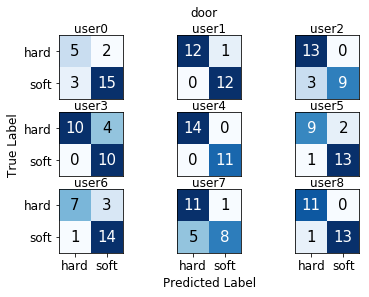

In [61]:
import itertools
import matplotlib.pyplot as plt
% matplotlib inline

fig = figure()
suptitle(material_plotnames[MATERIAL])
for row in range(3):
    for col in range(3):
        idx = row*3 + col
        ax = fig.add_subplot(3,3,idx+1)

        cax = ax.matshow(cms[idx], interpolation='nearest', cmap="Blues")

        for i, j in itertools.product(range(2), range(2)):
            plt.text(j, i, format(cms[idx][i, j], 'd'),
                 horizontalalignment="center",
                 verticalalignment='center',
                 fontsize=15,
                 color="white" if cms[idx][i, j] > cms.max()/2 else "black")
        
        tick_marks = np.arange(2)
        no_tick_marks = []
        pressures = ['hard', 'soft']
        if row == 2:
            plt.xticks(tick_marks, pressures, fontsize=12)
        else:
            plt.xticks(no_tick_marks);
        if col == 0:
            plt.yticks(tick_marks, pressures, fontsize=12)
        else:
            plt.yticks(no_tick_marks);
        ax.xaxis.set_ticks_position('bottom')
        
        
        #plt.tight_layout()
        ttl = plt.title("user"+str(idx))
        ttl.set_position([0.5, .95])
        
        if row == 2 and col == 1:
            plt.xlabel('Predicted Label', fontsize=12);
        if row == 1 and col == 0:
            plt.ylabel('True Label', fontsize=12);        


In [62]:
correct = 0
for i in range(9):
    correct += cms[i][0][0] + cms[i][1][1]
print("accuracy: {0:.2f}%".format(100*correct / cms.sum()))

accuracy: 79.12%
